In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.04 and 0.8 repectively. While the former is equal to the paramterization considered in Archambeau et al 2007, the latter is higher (0.8 vs 0.5)

Noisy Observations from the SDE:

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [16]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.7 # Variance is higher than the original example
obs_sigma = 0.04

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

Change dtype

In [17]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [18]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

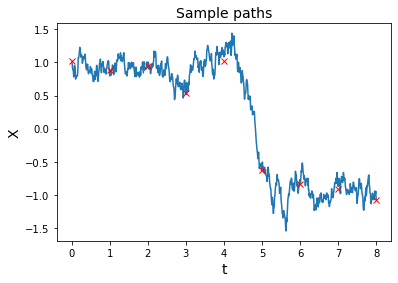

In [19]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [20]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [116]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

Variational inference: KL

In [90]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
                - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
                + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
                                                                                alpha * beta * B(s, beta-1))
        
        num = func(self.ou.pts, self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (-1 * (u ** 4) + (4+r)*(u ** 2)/2 - u*r*(alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
            
        
        return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [91]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [92]:
import tqdm as tq

In [97]:
D = 30

alpha_ = torch.tensor([0.])
beta_ = torch.rand(1)
r_ = torch.tensor([0.5])

m0 = obs[0].repeat(D, 1)


learning_rate = 0.001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(150)):
    alpha_D = alpha_.repeat(D, 1)
    beta_D = beta_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo_.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo_.KL_ito() + elbo_.KL_rest())
    

    trace_pars.append((beta_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0, r_D)
    f_of_X = -1 * (elbo.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
    beta_grad = torch.mean(f_of_X * scores['beta'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])

    # Update the parameter
    beta_ -= learning_rate * beta_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

  1%|▎                                          | 1/150 [00:00<00:19,  7.59it/s]

beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.0142, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.0362, dtype=torch.float64) var =  tensor(0.0148, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.0573, dtype=torch.float64) var =  tensor(0.0163, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.0854, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.1034, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.1033, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(1.1085, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.]) mean =  tensor(

  2%|▊                                          | 3/150 [00:00<00:18,  7.74it/s]

beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.9348, dtype=torch.float64) var =  tensor(0.0082, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.9334, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.9186, dtype=torch.float64) var =  tensor(0.0183, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.9230, dtype=torch.float64) var =  tensor(0.0139, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.8876, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.9056, dtype=torch.float64) var =  tensor(0.0144, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  tensor([0.0037]) mean =  tensor(0.9555, dtype=torch.float64) var =  tensor(0.0160, dtype=torch.float64)
beta =  tensor([0.0893]) alpha =  

  3%|█▏                                         | 4/150 [00:00<00:19,  7.65it/s]

beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0120, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0090, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0305, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0173, dtype=torch.float64) var =  tensor(0.0156, dtype=torch.float64)
beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0241, dtype=torch.float64) var =  tensor(0.0158, dtype=torch.float64)
beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0432, dtype=torch.float64) var =  tensor(0.0147, dtype=torch.float64)
beta =  tensor([0.0894]) alpha =  tensor([-0.0236]) mean =  tensor(1.0279, dtype=torch.float64) var =  tensor(0.0154, dtype=torch.float64)
beta =  tensor([0.0894]) al

  4%|█▋                                         | 6/150 [00:00<00:18,  7.69it/s]

tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9470, dtype=torch.float64) var =  tensor(0.0076, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9581, dtype=torch.float64) var =  tensor(0.0146, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9717, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9782, dtype=torch.float64) var =  tensor(0.0151, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9668, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9736, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.0925]) alpha =  tensor([-0.0352]) mean =  tensor(0.9462, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.

  5%|██                                         | 7/150 [00:00<00:18,  7.63it/s]

 var =  tensor(0.0157, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.8766, dtype=torch.float64) var =  tensor(0.0160, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.9009, dtype=torch.float64) var =  tensor(0.0141, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.9075, dtype=torch.float64) var =  tensor(0.0154, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.9277, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.9114, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.8959, dtype=torch.float64) var =  tensor(0.0092, dtype=torch.float64)
beta =  tensor([0.1005]) alpha =  tensor([-0.0567]) mean =  tensor(0.9136, dtype=torch.float64) var =  tensor(0.0086, dtyp

  6%|██▌                                        | 9/150 [00:01<00:18,  7.47it/s]

beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8122, dtype=torch.float64) var =  tensor(0.0128, dtype=torch.float64)
beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8464, dtype=torch.float64) var =  tensor(0.0154, dtype=torch.float64)
beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8765, dtype=torch.float64) var =  tensor(0.0150, dtype=torch.float64)
beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8687, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8633, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8638, dtype=torch.float64) var =  tensor(0.0136, dtype=torch.float64)
beta =  tensor([0.1162]) alpha =  tensor([-0.0838]) mean =  tensor(0.8842, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.1162]) al

  7%|██▊                                       | 10/150 [00:01<00:19,  7.36it/s]

beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.1063, dtype=torch.float64) var =  tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.1582, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.1560, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.1569, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.1925, dtype=torch.float64) var =  tensor(0.0130, dtype=torch.float64)
beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.2224, dtype=torch.float64) var =  tensor(0.0165, dtype=torch.float64)
beta =  tensor([0.1273]) alpha =  tensor([-0.0983]) mean =  tensor(1.1982, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.1273]) al

  8%|███▎                                      | 12/150 [00:01<00:18,  7.44it/s]

tensor(0.0089, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(0.9843, dtype=torch.float64) var =  tensor(0.0153, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(1.0034, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(0.9971, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(0.9609, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(0.9438, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(0.9674, dtype=torch.float64) var =  tensor(0.0147, dtype=torch.float64)
beta =  tensor([0.1259]) alpha =  tensor([-0.0965]) mean =  tensor(0.9839, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.

  9%|███▋                                      | 13/150 [00:01<00:18,  7.58it/s]

beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0479, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0404, dtype=torch.float64) var =  tensor(0.0086, dtype=torch.float64)
beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0286, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0375, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0217, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0386, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.1477]) alpha =  tensor([-0.1233]) mean =  tensor(1.0440, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.1477]) al

 10%|████▏                                     | 15/150 [00:01<00:17,  7.59it/s]

beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(0.9622, dtype=torch.float64) var =  tensor(0.0135, dtype=torch.float64)
beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(0.9810, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(1.0001, dtype=torch.float64) var =  tensor(0.0138, dtype=torch.float64)
beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(1.0106, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(0.9850, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(0.9911, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.1713]) alpha =  tensor([-0.1498]) mean =  tensor(0.9768, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.1713]) al

 11%|████▍                                     | 16/150 [00:02<00:17,  7.63it/s]

tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.0649, dtype=torch.float64) var =  tensor(0.0147, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.0971, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.1068, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.0839, dtype=torch.float64) var =  tensor(0.0133, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.0889, dtype=torch.float64) var =  tensor(0.0136, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.0846, dtype=torch.float64) var =  tensor(0.0142, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  tensor([-0.1561]) mean =  tensor(1.0636, dtype=torch.float64) var =  tensor(0.0136, dtype=torch.float64)
beta =  tensor([0.1772]) alpha =  t

 12%|█████                                     | 18/150 [00:02<00:17,  7.53it/s]

tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0417, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0501, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0420, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0568, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0848, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0685, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.1827]) alpha =  tensor([-0.1619]) mean =  tensor(1.0827, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.

 13%|█████▎                                    | 19/150 [00:02<00:17,  7.44it/s]

beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.0244, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.0531, dtype=torch.float64) var =  tensor(0.0140, dtype=torch.float64)
beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.0593, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.0808, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.0924, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.1024, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.2114]) alpha =  tensor([-0.1925]) mean =  tensor(1.1073, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.2114]) al

 14%|█████▉                                    | 21/150 [00:02<00:16,  7.68it/s]

beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(0.9973, dtype=torch.float64) var =  tensor(0.0128, dtype=torch.float64)
beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(1.0167, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(1.0340, dtype=torch.float64) var =  tensor(0.0164, dtype=torch.float64)
beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(1.0146, dtype=torch.float64) var =  tensor(0.0151, dtype=torch.float64)
beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(0.9675, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(0.9444, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.2004]) alpha =  tensor([-0.1814]) mean =  tensor(0.9619, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.2004]) al

 15%|██████▏                                   | 22/150 [00:02<00:16,  7.75it/s]

 var =  tensor(0.0133, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.9489, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.9526, dtype=torch.float64) var =  tensor(0.0152, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.9272, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.9027, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.8907, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.8805, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.2006]) alpha =  tensor([-0.1817]) mean =  tensor(0.9112, dtype=torch.float64) var =  tensor(0.0113, dtyp

 16%|██████▋                                   | 24/150 [00:03<00:16,  7.66it/s]

beta =  tensor([0.2213]) alpha =  tensor([-0.2031]) mean =  tensor(0.9728, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.2213]) alpha =  tensor([-0.2031]) mean =  tensor(0.9900, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.2213]) alpha =  tensor([-0.2031]) mean =  tensor(0.9717, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.2473]) alpha =  tensor([-0.2298]) mean =  tensor(1.0128, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.2473]) alpha =  tensor([-0.2298]) mean =  tensor(1.0415, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.2473]) alpha =  tensor([-0.2298]) mean =  tensor(1.0338, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.2473]) alpha =  tensor([-0.2298]) mean =  tensor(1.0245, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.2473]) al

 17%|███████                                   | 25/150 [00:03<00:16,  7.57it/s]

tensor(0.9614, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(0.9598, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(0.9670, dtype=torch.float64) var =  tensor(0.0150, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(0.9516, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(0.9528, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(0.9930, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(1.0393, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.2728]) alpha =  tensor([-0.2553]) mean =  tensor(1.0216, dtype=torch.

 18%|███████▌                                  | 27/150 [00:03<00:15,  7.72it/s]

tensor(0.0139, dtype=torch.float64)
beta =  tensor([0.2926]) alpha =  tensor([-0.2752]) mean =  tensor(1.0206, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.2926]) alpha =  tensor([-0.2752]) mean =  tensor(1.0377, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.2926]) alpha =  tensor([-0.2752]) mean =  tensor(1.0487, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.2926]) alpha =  tensor([-0.2752]) mean =  tensor(1.0680, dtype=torch.float64) var =  tensor(0.0153, dtype=torch.float64)
beta =  tensor([0.2926]) alpha =  tensor([-0.2752]) mean =  tensor(1.0801, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.2926]) alpha =  tensor([-0.2752]) mean =  tensor(1.0673, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3281]) alpha =  tensor([-0.3097]) mean =  tensor(1.0125, dtype=torch.float64) var =  tensor(0.0079, dtype=torch.

 19%|████████                                  | 29/150 [00:03<00:15,  7.71it/s]

beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(1.0114, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(0.9866, dtype=torch.float64) var =  tensor(0.0149, dtype=torch.float64)
beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(0.9550, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(0.9379, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(0.9422, dtype=torch.float64) var =  tensor(0.0147, dtype=torch.float64)
beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(0.9484, dtype=torch.float64) var =  tensor(0.0147, dtype=torch.float64)
beta =  tensor([0.3812]) alpha =  tensor([-0.3599]) mean =  tensor(0.9501, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3812]) al

 20%|████████▍                                 | 30/150 [00:03<00:15,  7.62it/s]

beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0526, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0382, dtype=torch.float64) var =  tensor(0.0138, dtype=torch.float64)
beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0429, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0312, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0179, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0146, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3922]) alpha =  tensor([-0.3694]) mean =  tensor(1.0120, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.3922]) al

 21%|████████▉                                 | 32/150 [00:04<00:15,  7.58it/s]

beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(0.9832, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(0.9835, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(1.0251, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(1.0188, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(0.9964, dtype=torch.float64) var =  tensor(0.0141, dtype=torch.float64)
beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(0.9673, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.3399]) alpha =  tensor([-0.3210]) mean =  tensor(0.9538, dtype=torch.float64) var =  tensor(0.0155, dtype=torch.float64)
beta =  tensor([0.3399]) al

 22%|█████████▏                                | 33/150 [00:04<00:15,  7.63it/s]

tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9708, dtype=torch.float64) var =  tensor(0.0076, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9712, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9554, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9483, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9889, dtype=torch.float64) var =  tensor(0.0152, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9508, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  tensor([-0.3120]) mean =  tensor(0.9684, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.3301]) alpha =  t

 23%|█████████▊                                | 35/150 [00:04<00:14,  7.72it/s]

tensor([-0.3291]) mean =  tensor(0.9845, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  tensor(0.9797, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  tensor(0.9927, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  tensor(0.9636, dtype=torch.float64) var =  tensor(0.0144, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  tensor(0.9636, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  tensor(0.9549, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  tensor(0.9543, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.3482]) alpha =  tensor([-0.3291]) mean =  t

 24%|██████████                                | 36/150 [00:04<00:15,  7.58it/s]

tensor(1.0769, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0707, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0923, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0657, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0260, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0179, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0255, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.2991]) alpha =  tensor([-0.2830]) mean =  tensor(1.0133, dtype=torch.

 25%|██████████▋                               | 38/150 [00:04<00:14,  7.70it/s]

beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(0.9807, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(0.9625, dtype=torch.float64) var =  tensor(0.0164, dtype=torch.float64)
beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(1.0040, dtype=torch.float64) var =  tensor(0.0069, dtype=torch.float64)
beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(1.0070, dtype=torch.float64) var =  tensor(0.0143, dtype=torch.float64)
beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(1.0212, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(1.0226, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.3102]) alpha =  tensor([-0.2939]) mean =  tensor(1.0084, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.3102]) al

 26%|██████████▉                               | 39/150 [00:05<00:14,  7.62it/s]

tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.8788, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.8901, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.8902, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.8876, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.8950, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.9278, dtype=torch.float64) var =  tensor(0.0086, dtype=torch.float64)
beta =  tensor([0.3330]) alpha =  tensor([-0.3153]) mean =  tensor(0.9048, dtype=torch.float64) var =  tensor(0.0149, dtype=torch.

 27%|███████████▍                              | 41/150 [00:05<00:14,  7.60it/s]

beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.9434, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.9414, dtype=torch.float64) var =  tensor(0.0151, dtype=torch.float64)
beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.9327, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.9039, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.8790, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.9053, dtype=torch.float64) var =  tensor(0.0130, dtype=torch.float64)
beta =  tensor([0.3727]) alpha =  tensor([-0.3529]) mean =  tensor(0.9279, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.3727]) al

 28%|███████████▊                              | 42/150 [00:05<00:14,  7.30it/s]

tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(1.0226, dtype=torch.float64) var =  tensor(0.0143, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(1.0431, dtype=torch.float64) var =  tensor(0.0144, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(1.0378, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(1.0306, dtype=torch.float64) var =  tensor(0.0084, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(1.0170, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(0.9991, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  tensor([-0.3573]) mean =  tensor(1.0126, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.3764]) alpha =  t

 29%|████████████                              | 43/150 [00:05<00:15,  7.03it/s]

tensor([-0.3498]) mean =  tensor(0.9935, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  tensor(0.9800, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  tensor(0.9980, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  tensor(0.9686, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  tensor(0.9819, dtype=torch.float64) var =  tensor(0.0139, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  tensor(0.9808, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  tensor(0.9984, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.3682]) alpha =  tensor([-0.3498]) mean =  t

 30%|████████████▌                             | 45/150 [00:05<00:15,  6.90it/s]

tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9736, dtype=torch.float64) var =  tensor(0.0093, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9525, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9353, dtype=torch.float64) var =  tensor(0.0133, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9094, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9107, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9208, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3633]) alpha =  tensor([-0.3455]) mean =  tensor(0.9213, dtype=torch.float64) var =  tensor(0.0157, dtype=torch.

 31%|████████████▉                             | 46/150 [00:06<00:14,  6.96it/s]

beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9715, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9720, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9435, dtype=torch.float64) var =  tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9297, dtype=torch.float64) var =  tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9413, dtype=torch.float64) var =  tensor(0.0133, dtype=torch.float64)
beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9391, dtype=torch.float64) var =  tensor(0.0083, dtype=torch.float64)
beta =  tensor([0.4145]) alpha =  tensor([-0.3926]) mean =  tensor(0.9609, dtype=torch.float64) var =  tensor(0.0080, dtype=torch.float64)
beta =  tensor([0.4145]) al

 32%|█████████████▍                            | 48/150 [00:06<00:13,  7.37it/s]

beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8609, dtype=torch.float64) var =  tensor(0.0143, dtype=torch.float64)
beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8313, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8409, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8491, dtype=torch.float64) var =  tensor(0.0071, dtype=torch.float64)
beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8235, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8275, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4468]) alpha =  tensor([-0.4216]) mean =  tensor(0.8398, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4468]) al

 33%|█████████████▋                            | 49/150 [00:06<00:13,  7.30it/s]

tensor(0.8972, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9209, dtype=torch.float64) var =  tensor(0.0140, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9242, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9406, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9306, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9381, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9165, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3956]) alpha =  tensor([-0.3744]) mean =  tensor(0.9077, dtype=torch.

 34%|██████████████▎                           | 51/150 [00:06<00:13,  7.56it/s]

tensor(0.9629, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9454, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9096, dtype=torch.float64) var =  tensor(0.0135, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9256, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9244, dtype=torch.float64) var =  tensor(0.0089, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9482, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9564, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.4041]) alpha =  tensor([-0.3824]) mean =  tensor(0.9731, dtype=torch.

 35%|██████████████▌                           | 52/150 [00:06<00:12,  7.63it/s]

tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.7905, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.7835, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.8086, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.8194, dtype=torch.float64) var =  tensor(0.0077, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.8343, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.8025, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  tensor([-0.3463]) mean =  tensor(0.7882, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3638]) alpha =  t

 36%|███████████████                           | 54/150 [00:07<00:12,  7.58it/s]

tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3712]) alpha =  tensor([-0.3532]) mean =  tensor(0.9120, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3712]) alpha =  tensor([-0.3532]) mean =  tensor(0.9124, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3712]) alpha =  tensor([-0.3532]) mean =  tensor(0.8967, dtype=torch.float64) var =  tensor(0.0155, dtype=torch.float64)
beta =  tensor([0.3712]) alpha =  tensor([-0.3532]) mean =  tensor(0.9236, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.3712]) alpha =  tensor([-0.3532]) mean =  tensor(0.9132, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3712]) alpha =  tensor([-0.3532]) mean =  tensor(0.9175, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.3715]) alpha =  tensor([-0.3533]) mean =  tensor(1.0106, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.

 37%|███████████████▍                          | 55/150 [00:07<00:12,  7.66it/s]

tensor(0.8903, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(0.8938, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(0.8983, dtype=torch.float64) var =  tensor(0.0144, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(0.8869, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(0.9231, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(0.8681, dtype=torch.float64) var =  tensor(0.0136, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(0.8315, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3987]) alpha =  tensor([-0.3781]) mean =  tensor(1.0106, dtype=torch.

 38%|███████████████▉                          | 57/150 [00:07<00:12,  7.60it/s]

beta =  tensor([0.4595]) alpha =  tensor([-0.4344]) mean =  tensor(0.9042, dtype=torch.float64) var =  tensor(0.0150, dtype=torch.float64)
beta =  tensor([0.4595]) alpha =  tensor([-0.4344]) mean =  tensor(0.8911, dtype=torch.float64) var =  tensor(0.0140, dtype=torch.float64)
beta =  tensor([0.4595]) alpha =  tensor([-0.4344]) mean =  tensor(0.9044, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4595]) alpha =  tensor([-0.4344]) mean =  tensor(0.8835, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4607]) alpha =  tensor([-0.4356]) mean =  tensor(1.0096, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.4607]) alpha =  tensor([-0.4356]) mean =  tensor(1.0252, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.4607]) alpha =  tensor([-0.4356]) mean =  tensor(0.9847, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4607]) al

 39%|████████████████▌                         | 59/150 [00:07<00:11,  7.71it/s]

beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(0.8165, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(1.0090, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(1.0285, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(1.0297, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(0.9757, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(0.9947, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.5256]) alpha =  tensor([-0.4950]) mean =  tensor(0.9449, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.5256]) al

 40%|████████████████▊                         | 60/150 [00:07<00:12,  7.47it/s]

beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(1.0300, dtype=torch.float64) var =  tensor(0.0080, dtype=torch.float64)
beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(1.0179, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(1.0194, dtype=torch.float64) var =  tensor(0.0082, dtype=torch.float64)
beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(0.9962, dtype=torch.float64) var =  tensor(0.0081, dtype=torch.float64)
beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(0.9882, dtype=torch.float64) var =  tensor(0.0143, dtype=torch.float64)
beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(0.9954, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.4884]) alpha =  tensor([-0.4616]) mean =  tensor(0.9986, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.4884]) al

 41%|█████████████████                         | 61/150 [00:08<00:12,  7.28it/s]

beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(0.8106, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(0.8663, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(0.8425, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(0.8357, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(0.8366, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(0.8189, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4783]) alpha =  tensor([-0.4515]) mean =  tensor(1.0081, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.4783]) al

 42%|█████████████████▋                        | 63/150 [00:08<00:12,  7.22it/s]

tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.8843, dtype=torch.float64) var =  tensor(0.0092, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.8789, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.8853, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.9099, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.9117, dtype=torch.float64) var =  tensor(0.0081, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.9072, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  tensor([-0.4472]) mean =  tensor(0.8868, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.4737]) alpha =  t

 43%|█████████████████▉                        | 64/150 [00:08<00:11,  7.23it/s]

tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9602, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9602, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9766, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9310, dtype=torch.float64) var =  tensor(0.0150, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9218, dtype=torch.float64) var =  tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9220, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.4730]) alpha =  tensor([-0.4471]) mean =  tensor(0.9249, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.

 44%|██████████████████▍                       | 66/150 [00:08<00:11,  7.35it/s]

tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8873, dtype=torch.float64) var =  tensor(0.0138, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8853, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8594, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8676, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8714, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8408, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4452]) alpha =  tensor([-0.4220]) mean =  tensor(0.8545, dtype=torch.float64) var =  tensor(0.0080, dtype=torch.

 45%|██████████████████▊                       | 67/150 [00:08<00:11,  7.31it/s]

 alpha =  tensor([-0.3879]) mean =  tensor(1.0167, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879]) mean =  tensor(1.0113, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879]) mean =  tensor(1.0029, dtype=torch.float64) var =  tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879]) mean =  tensor(1.0229, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879]) mean =  tensor(0.9889, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879]) mean =  tensor(0.9460, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879]) mean =  tensor(0.9419, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4065]) alpha =  tensor([-0.3879])

 46%|███████████████████▎                      | 69/150 [00:09<00:10,  7.66it/s]

tensor([-0.3445]) mean =  tensor(0.9343, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  tensor(0.9267, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  tensor(0.9512, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  tensor(0.9238, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  tensor(0.9366, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  tensor(0.9424, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  tensor(0.9112, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.3586]) alpha =  tensor([-0.3445]) mean =  t

 47%|███████████████████▉                      | 71/150 [00:09<00:10,  7.86it/s]

beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.9649, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.9740, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.9615, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.9377, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.9250, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.8974, dtype=torch.float64) var =  tensor(0.0089, dtype=torch.float64)
beta =  tensor([0.3395]) alpha =  tensor([-0.3274]) mean =  tensor(0.8923, dtype=torch.float64) var =  tensor(0.0092, dtype=torch.float64)
beta =  tensor([0.3395]) al

 48%|████████████████████▏                     | 72/150 [00:09<00:09,  7.88it/s]

beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0106, dtype=torch.float64) var =  tensor(0.0080, dtype=torch.float64)
beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0050, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0374, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0263, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0505, dtype=torch.float64) var =  tensor(0.0093, dtype=torch.float64)
beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0520, dtype=torch.float64) var =  tensor(0.0136, dtype=torch.float64)
beta =  tensor([0.4557]) alpha =  tensor([-0.4340]) mean =  tensor(1.0490, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.4557]) al

 49%|████████████████████▋                     | 74/150 [00:09<00:09,  8.00it/s]

beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(1.0025, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(0.9890, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(1.0042, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(0.9977, dtype=torch.float64) var =  tensor(0.0092, dtype=torch.float64)
beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(0.9808, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(0.9696, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.4506]) alpha =  tensor([-0.4298]) mean =  tensor(0.9668, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.4506]) al

 50%|█████████████████████                     | 75/150 [00:09<00:09,  7.70it/s]

tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9777, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9624, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9672, dtype=torch.float64) var =  tensor(0.0061, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9725, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9328, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9036, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  tensor([-0.3649]) mean =  tensor(0.9037, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3787]) alpha =  t

 51%|█████████████████████▌                    | 77/150 [00:10<00:09,  7.63it/s]

tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(0.9821, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(0.9940, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(1.0169, dtype=torch.float64) var =  tensor(0.0135, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(1.0070, dtype=torch.float64) var =  tensor(0.0078, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(0.9939, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(0.9882, dtype=torch.float64) var =  tensor(0.0128, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  tensor([-0.3436]) mean =  tensor(0.9921, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.3556]) alpha =  t

 52%|█████████████████████▊                    | 78/150 [00:10<00:09,  7.51it/s]

 tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(1.0117, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(0.9564, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(0.9618, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(0.9576, dtype=torch.float64) var =  tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(0.9730, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(1.0043, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  tensor([-0.3001]) mean =  tensor(1.0034, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.3075]) alpha =  

 53%|██████████████████████▍                   | 80/150 [00:10<00:09,  7.58it/s]

tensor(0.9589, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9563, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9525, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9649, dtype=torch.float64) var =  tensor(0.0144, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9705, dtype=torch.float64) var =  tensor(0.0138, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9852, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9895, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3355]) alpha =  tensor([-0.3260]) mean =  tensor(0.9929, dtype=torch.

 54%|██████████████████████▋                   | 81/150 [00:10<00:09,  7.21it/s]

beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(1.0690, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(1.0479, dtype=torch.float64) var =  tensor(0.0126, dtype=torch.float64)
beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(1.0211, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(1.0165, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(0.9970, dtype=torch.float64) var =  tensor(0.0092, dtype=torch.float64)
beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(0.9895, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.3228]) alpha =  tensor([-0.3139]) mean =  tensor(1.0000, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3228]) al

 55%|██████████████████████▉                   | 82/150 [00:10<00:09,  7.14it/s]

tensor([-0.3188]) mean =  tensor(1.0118, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  tensor(1.0115, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  tensor(0.9995, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  tensor(1.0197, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  tensor(1.0293, dtype=torch.float64) var =  tensor(0.0082, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  tensor(1.0156, dtype=torch.float64) var =  tensor(0.0133, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  tensor(0.9853, dtype=torch.float64) var =  tensor(0.0142, dtype=torch.float64)
beta =  tensor([0.3277]) alpha =  tensor([-0.3188]) mean =  t

 56%|███████████████████████▌                  | 84/150 [00:11<00:09,  7.10it/s]

beta =  tensor([0.3207]) alpha =  tensor([-0.3126]) mean =  tensor(0.9134, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.3207]) alpha =  tensor([-0.3126]) mean =  tensor(0.9071, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3207]) alpha =  tensor([-0.3126]) mean =  tensor(0.9054, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.3207]) alpha =  tensor([-0.3126]) mean =  tensor(0.9089, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.3207]) alpha =  tensor([-0.3126]) mean =  tensor(0.8807, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.3207]) alpha =  tensor([-0.3126]) mean =  tensor(0.8928, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.3116]) alpha =  tensor([-0.3043]) mean =  tensor(1.0117, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3116]) al

 57%|███████████████████████▊                  | 85/150 [00:11<00:09,  7.20it/s]

tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(0.9622, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(0.9682, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(0.9569, dtype=torch.float64) var =  tensor(0.0081, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(0.9531, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(0.9964, dtype=torch.float64) var =  tensor(0.0086, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(0.9905, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.3049]) alpha =  tensor([-0.2980]) mean =  tensor(1.0248, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.

 58%|████████████████████████▎                 | 87/150 [00:11<00:08,  7.23it/s]

beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.9856, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.9925, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.9473, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.9393, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.9309, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.9053, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3073]) alpha =  tensor([-0.3002]) mean =  tensor(0.8902, dtype=torch.float64) var =  tensor(0.0086, dtype=torch.float64)
beta =  tensor([0.3073]) al

 59%|████████████████████████▋                 | 88/150 [00:11<00:08,  7.24it/s]

tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(1.0051, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(1.0341, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(1.0040, dtype=torch.float64) var =  tensor(0.0083, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(0.9959, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(0.9795, dtype=torch.float64) var =  tensor(0.0068, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(0.9977, dtype=torch.float64) var =  tensor(0.0130, dtype=torch.float64)
beta =  tensor([0.3315]) alpha =  tensor([-0.3231]) mean =  tensor(0.9808, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.

 60%|█████████████████████████▏                | 90/150 [00:12<00:08,  7.37it/s]

beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(1.0273, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(1.0082, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(1.0009, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(1.0300, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(1.0110, dtype=torch.float64) var =  tensor(0.0079, dtype=torch.float64)
beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(0.9957, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.2988]) alpha =  tensor([-0.2933]) mean =  tensor(1.0307, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.2988]) al

 61%|█████████████████████████▍                | 91/150 [00:12<00:08,  7.35it/s]

tensor(0.0153, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(0.9837, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(1.0122, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(1.0022, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(1.0148, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(1.0119, dtype=torch.float64) var =  tensor(0.0142, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(0.9975, dtype=torch.float64) var =  tensor(0.0081, dtype=torch.float64)
beta =  tensor([0.3203]) alpha =  tensor([-0.3130]) mean =  tensor(0.9925, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.

 62%|██████████████████████████                | 93/150 [00:12<00:07,  7.44it/s]

tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0563, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0883, dtype=torch.float64) var =  tensor(0.0125, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0997, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0933, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0716, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0447, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.3300]) alpha =  tensor([-0.3221]) mean =  tensor(1.0428, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.

 63%|██████████████████████████▎               | 94/150 [00:12<00:07,  7.46it/s]

tensor([-0.5052]) mean =  tensor(0.9154, dtype=torch.float64) var =  tensor(0.0077, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  tensor(0.9000, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  tensor(0.9133, dtype=torch.float64) var =  tensor(0.0154, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  tensor(0.9095, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  tensor(0.9172, dtype=torch.float64) var =  tensor(0.0083, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  tensor(0.8975, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  tensor(0.8705, dtype=torch.float64) var =  tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.5301]) alpha =  tensor([-0.5052]) mean =  t

 64%|██████████████████████████▉               | 96/150 [00:12<00:07,  7.68it/s]

tensor([-0.5040]) mean =  tensor(0.8368, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  tensor(0.8185, dtype=torch.float64) var =  tensor(0.0130, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  tensor(0.8102, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  tensor(0.8050, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  tensor(0.8024, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  tensor(0.7933, dtype=torch.float64) var =  tensor(0.0080, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  tensor(0.7722, dtype=torch.float64) var =  tensor(0.0077, dtype=torch.float64)
beta =  tensor([0.5280]) alpha =  tensor([-0.5040]) mean =  t

 65%|███████████████████████████▏              | 97/150 [00:12<00:06,  7.64it/s]

tensor([-0.4406]) mean =  tensor(0.8252, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  tensor(0.8162, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  tensor(0.8080, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  tensor(0.8133, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  tensor(0.8240, dtype=torch.float64) var =  tensor(0.0130, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  tensor(0.8048, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  tensor(0.8056, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.4577]) alpha =  tensor([-0.4406]) mean =  t

 66%|███████████████████████████▋              | 99/150 [00:13<00:06,  7.54it/s]

beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.8616, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.8828, dtype=torch.float64) var =  tensor(0.0135, dtype=torch.float64)
beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.8562, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.8239, dtype=torch.float64) var =  tensor(0.0084, dtype=torch.float64)
beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.8413, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.8735, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.4417]) alpha =  tensor([-0.4272]) mean =  tensor(0.9002, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4417]) al

 67%|███████████████████████████▎             | 100/150 [00:13<00:06,  7.44it/s]

beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.8946, dtype=torch.float64) var =  tensor(0.0051, dtype=torch.float64)
beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.9022, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.8939, dtype=torch.float64) var =  tensor(0.0079, dtype=torch.float64)
beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.8516, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.8310, dtype=torch.float64) var =  tensor(0.0083, dtype=torch.float64)
beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.8077, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.5147]) alpha =  tensor([-0.4913]) mean =  tensor(0.7833, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.5147]) al

 68%|███████████████████████████▉             | 102/150 [00:13<00:06,  7.57it/s]

tensor([-0.4726]) mean =  tensor(0.8182, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  tensor(0.8257, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  tensor(0.8497, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  tensor(0.8664, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  tensor(0.8179, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  tensor(0.8138, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  tensor(0.7705, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.4940]) alpha =  tensor([-0.4726]) mean =  t

 69%|████████████████████████████▏            | 103/150 [00:13<00:06,  7.64it/s]

tensor([-0.4180]) mean =  tensor(0.9768, dtype=torch.float64) var =  tensor(0.0084, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  tensor(0.9511, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  tensor(0.9410, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  tensor(0.9338, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  tensor(0.9245, dtype=torch.float64) var =  tensor(0.0135, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  tensor(0.8945, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  tensor(0.8865, dtype=torch.float64) var =  tensor(0.0084, dtype=torch.float64)
beta =  tensor([0.4330]) alpha =  tensor([-0.4180]) mean =  t

 70%|████████████████████████████▋            | 105/150 [00:14<00:06,  7.37it/s]

tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.9207, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.9118, dtype=torch.float64) var =  tensor(0.0075, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.9047, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.8723, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.8831, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.8820, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.4081]) alpha =  tensor([-0.3958]) mean =  tensor(0.9051, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.

 71%|████████████████████████████▉            | 106/150 [00:14<00:06,  7.20it/s]

tensor(0.9293, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.9284, dtype=torch.float64) var =  tensor(0.0163, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.9215, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.8860, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.8877, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.8668, dtype=torch.float64) var =  tensor(0.0078, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.8594, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.4035]) alpha =  tensor([-0.3922]) mean =  tensor(0.8465, dtype=torch.

 72%|█████████████████████████████▌           | 108/150 [00:14<00:05,  7.54it/s]

tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8320, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8488, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8781, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8809, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8724, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8781, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  tensor([-0.4172]) mean =  tensor(0.8673, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4313]) alpha =  t

 73%|█████████████████████████████▊           | 109/150 [00:14<00:05,  7.66it/s]

beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.8954, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.9005, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.8792, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.8798, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.9185, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.9091, dtype=torch.float64) var =  tensor(0.0073, dtype=torch.float64)
beta =  tensor([0.3716]) alpha =  tensor([-0.3623]) mean =  tensor(0.9008, dtype=torch.float64) var =  tensor(0.0133, dtype=torch.float64)
beta =  tensor([0.3716]) al

 74%|██████████████████████████████▎          | 111/150 [00:14<00:05,  7.65it/s]

beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.9181, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.8956, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.9076, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.9341, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.9181, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.9337, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3449]) alpha =  tensor([-0.3382]) mean =  tensor(0.9263, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.3621]) al

 75%|██████████████████████████████▌          | 112/150 [00:14<00:05,  7.49it/s]


beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9491, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9559, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9584, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9358, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9272, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9149, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.3524]) alpha =  tensor([-0.3456]) mean =  tensor(0.9106, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3524]) a

 76%|███████████████████████████████▏         | 114/150 [00:15<00:04,  7.46it/s]

beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9818, dtype=torch.float64) var =  tensor(0.0135, dtype=torch.float64)
beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9748, dtype=torch.float64) var =  tensor(0.0154, dtype=torch.float64)
beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9753, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9810, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9478, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9375, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.3820]) alpha =  tensor([-0.3722]) mean =  tensor(0.9291, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.3820]) al

 77%|███████████████████████████████▍         | 115/150 [00:15<00:04,  7.44it/s]

beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9165, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9310, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9304, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9643, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9628, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9595, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4256]) alpha =  tensor([-0.4119]) mean =  tensor(0.9690, dtype=torch.float64) var =  tensor(0.0075, dtype=torch.float64)
beta =  tensor([0.4256]) al

 78%|███████████████████████████████▉         | 117/150 [00:15<00:04,  7.47it/s]

tensor([-0.4065]) mean =  tensor(0.9286, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  tensor(0.9454, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  tensor(0.9600, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  tensor(0.9399, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  tensor(0.9056, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  tensor(0.8740, dtype=torch.float64) var =  tensor(0.0102, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  tensor(0.8571, dtype=torch.float64) var =  tensor(0.0067, dtype=torch.float64)
beta =  tensor([0.4184]) alpha =  tensor([-0.4065]) mean =  t

 79%|████████████████████████████████▎        | 118/150 [00:15<00:04,  7.45it/s]

tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.9144, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.9127, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.8706, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.9094, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.8971, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.8671, dtype=torch.float64) var =  tensor(0.0081, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  tensor([-0.4018]) mean =  tensor(0.8519, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.4134]) alpha =  t

 80%|████████████████████████████████▊        | 120/150 [00:16<00:03,  7.56it/s]

tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9510, dtype=torch.float64) var =  tensor(0.0129, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9281, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9480, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9585, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9800, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9197, dtype=torch.float64) var =  tensor(0.0137, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  tensor([-0.4121]) mean =  tensor(0.9026, dtype=torch.float64) var =  tensor(0.0092, dtype=torch.float64)
beta =  tensor([0.4250]) alpha =  t

 81%|█████████████████████████████████        | 121/150 [00:16<00:03,  7.62it/s]

beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.9032, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.8942, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.8631, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.8611, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.8651, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.8444, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.3532]) alpha =  tensor([-0.3480]) mean =  tensor(0.8423, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.3532]) al

 82%|█████████████████████████████████▌       | 123/150 [00:16<00:03,  7.70it/s]

beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(1.0087, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(1.0092, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(1.0218, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(1.0268, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(1.0231, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(1.0004, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.4655]) alpha =  tensor([-0.4500]) mean =  tensor(0.9893, dtype=torch.float64) var =  tensor(0.0109, dtype=torch.float64)
beta =  tensor([0.4655]) al

 83%|██████████████████████████████████▏      | 125/150 [00:16<00:03,  7.72it/s]

beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(0.9812, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(0.9445, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(0.9615, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(0.9360, dtype=torch.float64) var =  tensor(0.0080, dtype=torch.float64)
beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(0.9429, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(0.9918, dtype=torch.float64) var =  tensor(0.0098, dtype=torch.float64)
beta =  tensor([0.5254]) alpha =  tensor([-0.5037]) mean =  tensor(1.0269, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.5254]) al

 84%|██████████████████████████████████▍      | 126/150 [00:16<00:03,  7.61it/s]

tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(0.9750, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(1.0050, dtype=torch.float64) var =  tensor(0.0120, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(0.9980, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(0.9894, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(1.0109, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(1.0045, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  tensor([-0.4171]) mean =  tensor(0.9869, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.4255]) alpha =  t

 85%|██████████████████████████████████▉      | 128/150 [00:17<00:02,  7.59it/s]

tensor(0.0082, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(0.9769, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(0.9574, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(0.9812, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(0.9650, dtype=torch.float64) var =  tensor(0.0134, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(0.9785, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(0.9901, dtype=torch.float64) var =  tensor(0.0079, dtype=torch.float64)
beta =  tensor([0.4352]) alpha =  tensor([-0.4259]) mean =  tensor(1.0087, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.

 86%|███████████████████████████████████▎     | 129/150 [00:17<00:02,  7.64it/s]

beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(1.0092, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(1.0300, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(1.0187, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(0.9979, dtype=torch.float64) var =  tensor(0.0091, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(1.0019, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(0.9933, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4279]) mean =  tensor(0.9771, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.4394]) al

 87%|███████████████████████████████████▊     | 131/150 [00:17<00:02,  7.68it/s]

tensor([-0.4232]) mean =  tensor(0.9436, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  tensor(0.9265, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  tensor(0.9620, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  tensor(0.9675, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  tensor(0.9334, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  tensor(0.9541, dtype=torch.float64) var =  tensor(0.0086, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  tensor(0.9595, dtype=torch.float64) var =  tensor(0.0099, dtype=torch.float64)
beta =  tensor([0.4338]) alpha =  tensor([-0.4232]) mean =  t

 88%|████████████████████████████████████     | 132/150 [00:17<00:02,  7.57it/s]

tensor([-0.4983]) mean =  tensor(0.8834, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  tensor(0.8688, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  tensor(0.8412, dtype=torch.float64) var =  tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  tensor(0.8416, dtype=torch.float64) var =  tensor(0.0093, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  tensor(0.8300, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  tensor(0.8146, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  tensor(0.8293, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.5165]) alpha =  tensor([-0.4983]) mean =  t

 89%|████████████████████████████████████▋    | 134/150 [00:17<00:02,  7.46it/s]

tensor([-0.4306]) mean =  tensor(0.9489, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  tensor(0.9383, dtype=torch.float64) var =  tensor(0.0143, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  tensor(0.9431, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  tensor(0.9303, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  tensor(0.9116, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  tensor(0.9047, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  tensor(0.8917, dtype=torch.float64) var =  tensor(0.0121, dtype=torch.float64)
beta =  tensor([0.4394]) alpha =  tensor([-0.4306]) mean =  t

 90%|████████████████████████████████████▉    | 135/150 [00:17<00:02,  7.39it/s]

tensor(0.9826, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.9767, dtype=torch.float64) var =  tensor(0.0094, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.9378, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.9163, dtype=torch.float64) var =  tensor(0.0165, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.9269, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.9043, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.9049, dtype=torch.float64) var =  tensor(0.0124, dtype=torch.float64)
beta =  tensor([0.4165]) alpha =  tensor([-0.4111]) mean =  tensor(0.8929, dtype=torch.

 91%|█████████████████████████████████████▍   | 137/150 [00:18<00:01,  7.56it/s]

beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9888, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9868, dtype=torch.float64) var =  tensor(0.0107, dtype=torch.float64)
beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9855, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9410, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9088, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9136, dtype=torch.float64) var =  tensor(0.0117, dtype=torch.float64)
beta =  tensor([0.4085]) alpha =  tensor([-0.4037]) mean =  tensor(0.9191, dtype=torch.float64) var =  tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.4085]) al

 92%|█████████████████████████████████████▋   | 138/150 [00:18<00:01,  7.55it/s]

tensor(0.0093, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9394, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9188, dtype=torch.float64) var =  tensor(0.0077, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9248, dtype=torch.float64) var =  tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9344, dtype=torch.float64) var =  tensor(0.0118, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9208, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9188, dtype=torch.float64) var =  tensor(0.0142, dtype=torch.float64)
beta =  tensor([0.3775]) alpha =  tensor([-0.3760]) mean =  tensor(0.9195, dtype=torch.float64) var =  tensor(0.0070, dtype=torch.

 93%|██████████████████████████████████████▎  | 140/150 [00:18<00:01,  7.68it/s]

beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9602, dtype=torch.float64) var =  tensor(0.0101, dtype=torch.float64)
beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9528, dtype=torch.float64) var =  tensor(0.0105, dtype=torch.float64)
beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9662, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9677, dtype=torch.float64) var =  tensor(0.0104, dtype=torch.float64)
beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9617, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9275, dtype=torch.float64) var =  tensor(0.0116, dtype=torch.float64)
beta =  tensor([0.3603]) alpha =  tensor([-0.3610]) mean =  tensor(0.9324, dtype=torch.float64) var =  tensor(0.0096, dtype=torch.float64)
beta =  tensor([0.3603]) al

 94%|██████████████████████████████████████▌  | 141/150 [00:18<00:01,  7.44it/s]

tensor(0.9815, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9853, dtype=torch.float64) var =  tensor(0.0111, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9912, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9437, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9396, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9413, dtype=torch.float64) var =  tensor(0.0110, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9602, dtype=torch.float64) var =  tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.3666]) alpha =  tensor([-0.3661]) mean =  tensor(0.9795, dtype=torch.

 95%|███████████████████████████████████████  | 143/150 [00:19<00:00,  7.49it/s]

tensor(0.9373, dtype=torch.float64) var =  tensor(0.0112, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.9287, dtype=torch.float64) var =  tensor(0.0136, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.9546, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.9518, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.9176, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.9230, dtype=torch.float64) var =  tensor(0.0140, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.8711, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3795]) alpha =  tensor([-0.3774]) mean =  tensor(0.8800, dtype=torch.

 96%|███████████████████████████████████████▎ | 144/150 [00:19<00:00,  7.65it/s]

tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9829, dtype=torch.float64) var =  tensor(0.0106, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9681, dtype=torch.float64) var =  tensor(0.0122, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9604, dtype=torch.float64) var =  tensor(0.0089, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9527, dtype=torch.float64) var =  tensor(0.0084, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9396, dtype=torch.float64) var =  tensor(0.0089, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9294, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  tensor([-0.3438]) mean =  tensor(0.9263, dtype=torch.float64) var =  tensor(0.0132, dtype=torch.float64)
beta =  tensor([0.3412]) alpha =  t

 97%|███████████████████████████████████████▉ | 146/150 [00:19<00:00,  7.78it/s]

beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.9102, dtype=torch.float64) var =  tensor(0.0093, dtype=torch.float64)
beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.9081, dtype=torch.float64) var =  tensor(0.0090, dtype=torch.float64)
beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.8912, dtype=torch.float64) var =  tensor(0.0103, dtype=torch.float64)
beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.9198, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.9295, dtype=torch.float64) var =  tensor(0.0113, dtype=torch.float64)
beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.9080, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3769]) alpha =  tensor([-0.3759]) mean =  tensor(0.9125, dtype=torch.float64) var =  tensor(0.0119, dtype=torch.float64)
beta =  tensor([0.3769]) al

 98%|████████████████████████████████████████▏| 147/150 [00:19<00:00,  7.87it/s]

beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(0.8898, dtype=torch.float64) var =  tensor(0.0077, dtype=torch.float64)
beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(0.8555, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(0.8161, dtype=torch.float64) var =  tensor(0.0095, dtype=torch.float64)
beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(0.8278, dtype=torch.float64) var =  tensor(0.0175, dtype=torch.float64)
beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(0.8276, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(0.8388, dtype=torch.float64) var =  tensor(0.0087, dtype=torch.float64)
beta =  tensor([0.3434]) alpha =  tensor([-0.3459]) mean =  tensor(1.0112, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3434]) al

 99%|████████████████████████████████████████▋| 149/150 [00:19<00:00,  7.72it/s]

beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(1.0120, dtype=torch.float64) var =  tensor(0.0083, dtype=torch.float64)
beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(0.9927, dtype=torch.float64) var =  tensor(0.0154, dtype=torch.float64)
beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(0.9901, dtype=torch.float64) var =  tensor(0.0076, dtype=torch.float64)
beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(0.9674, dtype=torch.float64) var =  tensor(0.0100, dtype=torch.float64)
beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(0.9501, dtype=torch.float64) var =  tensor(0.0123, dtype=torch.float64)
beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(0.9149, dtype=torch.float64) var =  tensor(0.0130, dtype=torch.float64)
beta =  tensor([0.3425]) alpha =  tensor([-0.3450]) mean =  tensor(0.9236, dtype=torch.float64) var =  tensor(0.0085, dtype=torch.float64)
beta =  tensor([0.3425]) al

100%|█████████████████████████████████████████| 150/150 [00:19<00:00,  7.52it/s]

tensor(0.0097, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(0.9210, dtype=torch.float64) var =  tensor(0.0128, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(0.9272, dtype=torch.float64) var =  tensor(0.0114, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(0.9168, dtype=torch.float64) var =  tensor(0.0115, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(1.0106, dtype=torch.float64) var =  tensor(0.0108, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(1.0253, dtype=torch.float64) var =  tensor(0.0088, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(1.0281, dtype=torch.float64) var =  tensor(0.0131, dtype=torch.float64)
beta =  tensor([0.3813]) alpha =  tensor([-0.3795]) mean =  tensor(0.9917, dtype=torch.float64) var =  tensor(0.0127, dtype=torch.

**Posterior mean**

In [98]:
compute_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0[0]

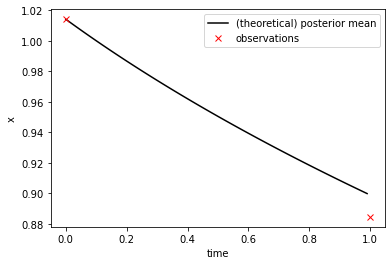

In [99]:
plt.plot(true_sde_pts[:100], compute_mean(true_sde_pts)[:100], color='black', label="(theoretical) posterior mean")
plt.plot(true_sde_pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(1.0092, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(1.0123, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(0.9979, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(1.0009, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(0.9844, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(0.9999, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(0.9890, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(0.9556, dtype=torch.float64) var =  tensor(0.0306)
beta =  tensor(0.3820) alpha =  tensor(-0.3804) mean =  tensor(0.9580, dtype=torch.float

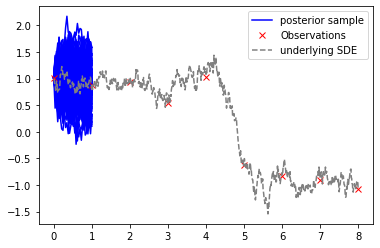

In [100]:
S = 100
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = m0[0].repeat(S, 1), m0 = m0[0].repeat(S, 1), alpha = alpha_, beta = beta_, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(posterior.pts.T[0], posterior.trj.T[0], 'b', label="posterior sample")
plt.plot(obs_time, obs, 'rx', label='Observations')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed', label="underlying SDE")
plt.legend()
plt.show()

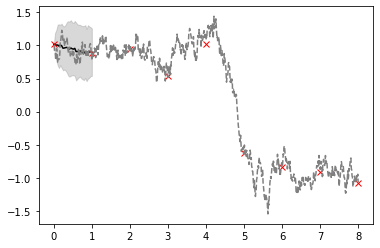

In [101]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed')

**Trace plot: parameters**

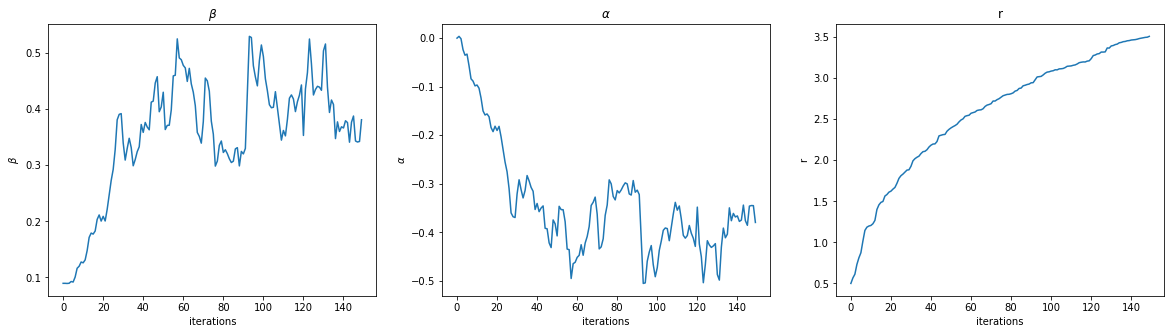

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

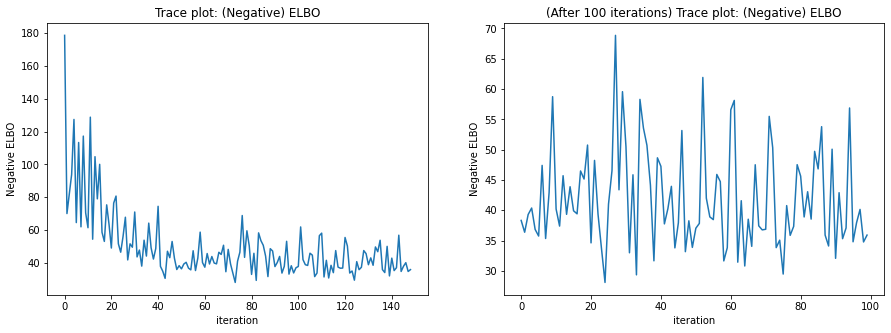

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior credible interval (constructed by monte carlo estimator based on sample from time-depenent OU with fitted variational parameters**

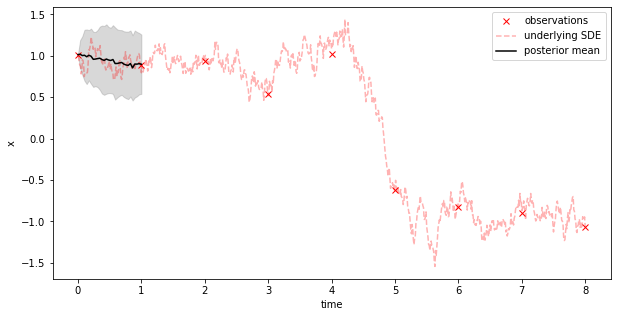

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde_pts,true_sde_trj, 'red', linestyle='dashed', alpha= 0.3, label='underlying SDE')
plt.plot(posterior.pts[0], post_mean, color='black', label="posterior mean")
plt.fill_between(posterior.pts[0], post_mean - post_std, post_mean + post_std, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [134]:
D = 100
S = 50
learning_rate = 0.0001
lr = learning_rate
IT = 200
dN = 30
z0 = obs[0]

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT))
KL_traces = np.empty((len(obs_time) -1 , IT))
NLL_traces = np.empty((len(obs_time) -1 , IT))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    beta_ = torch.rand(1)
    r_ = torch.rand(1)
    i = 0
    conv = 1
    while (conv > 0.00005) and (i < IT): 
#         print("after z0 = ", z0)
        old = alpha_ + beta_ + r_
        
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_ito() + elbo_.KL_rest()
            NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + NLL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            NLL_traces[t, i-1] = torch.mean(NLL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D, z0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter
#         if torch.nanmean(f_of_X) > 1e+6:
#             beta_ -= 0.0000001 * beta_grad
#             alpha_ -= 0.0000001 * alpha_grad
#             r__ = r_ - 0.0000001 * r_grad
#         else:
        beta_ -= learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()
        pars_traces[2, t, i] = r_.clone()

        new = alpha_.clone() + beta_.clone() + r_.clone()
#         conv = abs(old - new)
        
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = z0.repeat(S, 1), alpha = alpha_, beta = beta_, sigma = sde_sigma, r = r_, D = S, dN = dN, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-0.01417547] beta =  [0.386549] r =  [0.33895546]
(Neg) elbo =  163.06712032380216
alpha =  [-0.21505716] beta =  [0.44709948] r =  [0.83013296]
(Neg) elbo =  104.31895224663414
alpha =  [-0.342479] beta =  [0.5293139] r =  [1.1299098]
(Neg) elbo =  72.47496707507274
alpha =  [-0.38428262] beta =  [0.5584192] r =  [1.3814075]
(Neg) elbo =  72.19618049494058


 12%|█████▋                                       | 1/8 [00:10<01:12, 10.38s/it]

alpha =  [0.00276808] beta =  [0.35224593] r =  [0.7684503]
(Neg) elbo =  103.5322809655891
alpha =  [0.23209804] beta =  [0.4363172] r =  [1.046504]
(Neg) elbo =  77.00398023538206
alpha =  [0.33456665] beta =  [0.5160796] r =  [1.2909508]
(Neg) elbo =  75.40870900343886
alpha =  [0.31943968] beta =  [0.5035504] r =  [1.476603]
(Neg) elbo =  53.39401406268848


 25%|███████████▎                                 | 2/8 [00:20<01:02, 10.40s/it]

alpha =  [-5.0994777e-06] beta =  [0.00020945] r =  [0.6223711]
(Neg) elbo =  152.9687487093387
alpha =  [-0.00041137] beta =  [0.00045946] r =  [1.0483215]
(Neg) elbo =  109.80330753075273
alpha =  [-0.00169496] beta =  [0.00170743] r =  [1.2820579]
(Neg) elbo =  137.899806427177
alpha =  [-0.00758641] beta =  [0.00760273] r =  [1.4868454]
(Neg) elbo =  130.04030119820476


 38%|████████████████▉                            | 3/8 [00:31<00:51, 10.33s/it]

alpha =  [-0.02692695] beta =  [0.8763452] r =  [0.2545057]
(Neg) elbo =  151.75911106876316
alpha =  [-0.042348] beta =  [0.85230166] r =  [0.8419724]
(Neg) elbo =  105.67233224783975
alpha =  [0.01399578] beta =  [0.8361868] r =  [1.1474003]
(Neg) elbo =  59.4674000635311
alpha =  [0.02079343] beta =  [0.8228447] r =  [1.3754194]
(Neg) elbo =  65.50232366270728


 50%|██████████████████████▌                      | 4/8 [00:41<00:41, 10.30s/it]

alpha =  [-0.01277846] beta =  [0.22913945] r =  [0.545226]
(Neg) elbo =  1199.5783426480264
alpha =  [-0.66665167] beta =  [0.8602259] r =  [0.97970223]
(Neg) elbo =  66.36976364289848
alpha =  [-0.65094054] beta =  [0.7994624] r =  [1.1892344]
(Neg) elbo =  65.84820720763055
alpha =  [-0.65834713] beta =  [0.7884095] r =  [1.3751272]
(Neg) elbo =  51.58220269611736


 62%|████████████████████████████▏                | 5/8 [00:51<00:30, 10.30s/it]

alpha =  [0.00025508] beta =  [0.164051] r =  [0.5051146]
(Neg) elbo =  147.57789110295636
alpha =  [-0.01388637] beta =  [0.16426517] r =  [0.8867695]
(Neg) elbo =  73.10242653555278
alpha =  [-0.0092219] beta =  [0.16334222] r =  [1.1483936]
(Neg) elbo =  53.02009443908838
alpha =  [-0.01416275] beta =  [0.163226] r =  [1.3505063]
(Neg) elbo =  54.9892902886048


 75%|█████████████████████████████████▊           | 6/8 [01:02<00:20, 10.33s/it]

alpha =  [-0.00881315] beta =  [0.8035557] r =  [0.19973916]
(Neg) elbo =  123.88741256245322
alpha =  [-0.02959458] beta =  [0.78866166] r =  [0.7139747]
(Neg) elbo =  92.70002859714927
alpha =  [-0.03513762] beta =  [0.76271737] r =  [1.0155922]
(Neg) elbo =  75.7456805088469
alpha =  [-0.02894188] beta =  [0.7385113] r =  [1.2393999]
(Neg) elbo =  56.7025772346799


 88%|███████████████████████████████████████▍     | 7/8 [01:12<00:10, 10.37s/it]

alpha =  [-0.03530009] beta =  [0.69857323] r =  [0.9687878]
(Neg) elbo =  69.31600112138416
alpha =  [-0.0690506] beta =  [0.6786114] r =  [1.2275629]
(Neg) elbo =  62.09837289534393
alpha =  [-0.08669662] beta =  [0.6445233] r =  [1.4648888]
(Neg) elbo =  62.13553144104876
alpha =  [-0.08447817] beta =  [0.61506236] r =  [1.6449463]
(Neg) elbo =  62.69523259980856


100%|█████████████████████████████████████████████| 8/8 [01:22<00:00, 10.36s/it]


Trace plot: ELBO

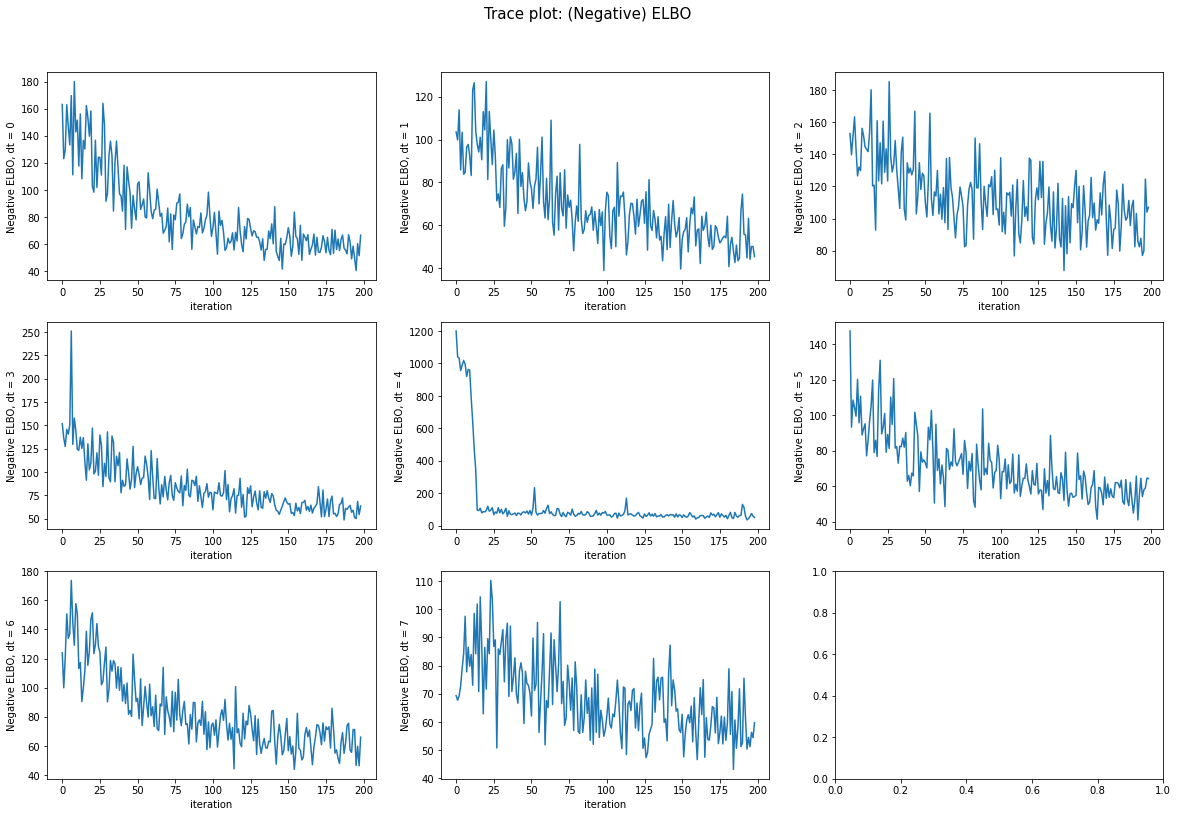

In [144]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :-1])), elbo_traces[t, :-1])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

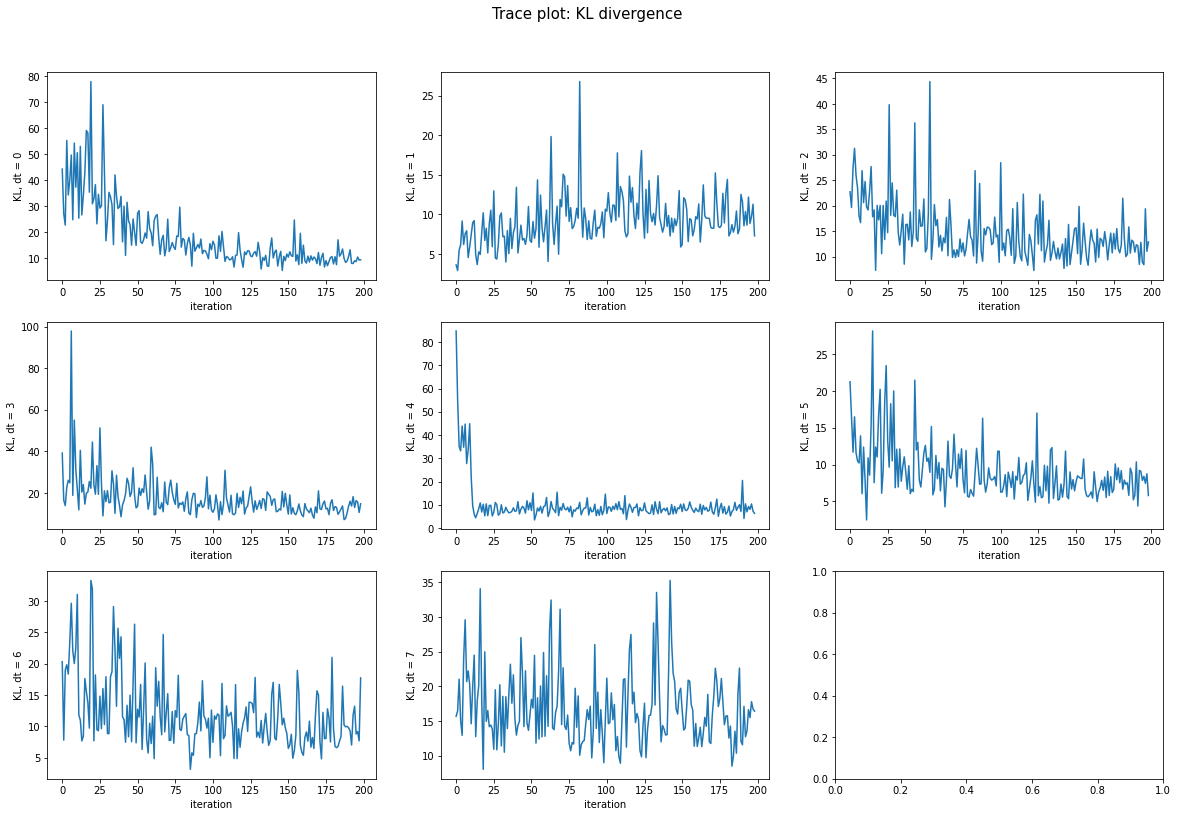

In [145]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :-1])), -1 * KL_traces[t, :-1])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

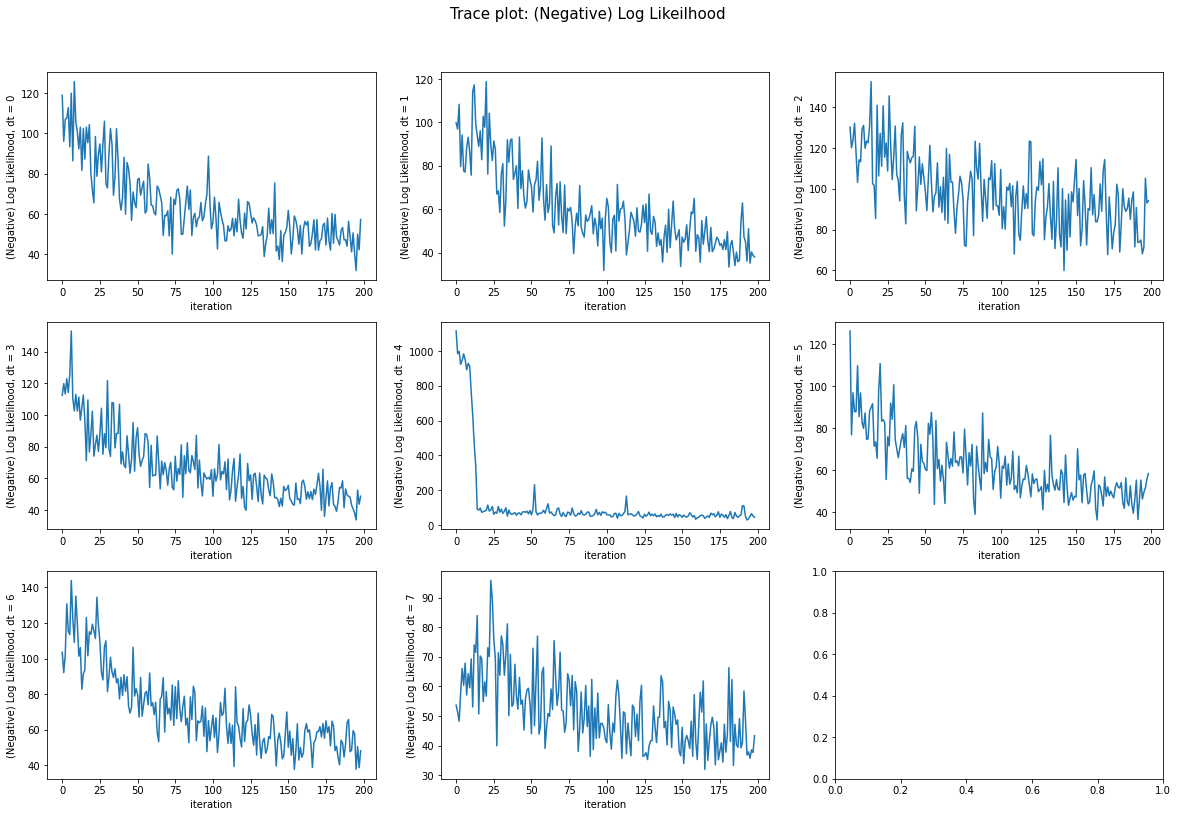

In [146]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(NLL_traces[t, :-1])), -1 * NLL_traces[t, :-1])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

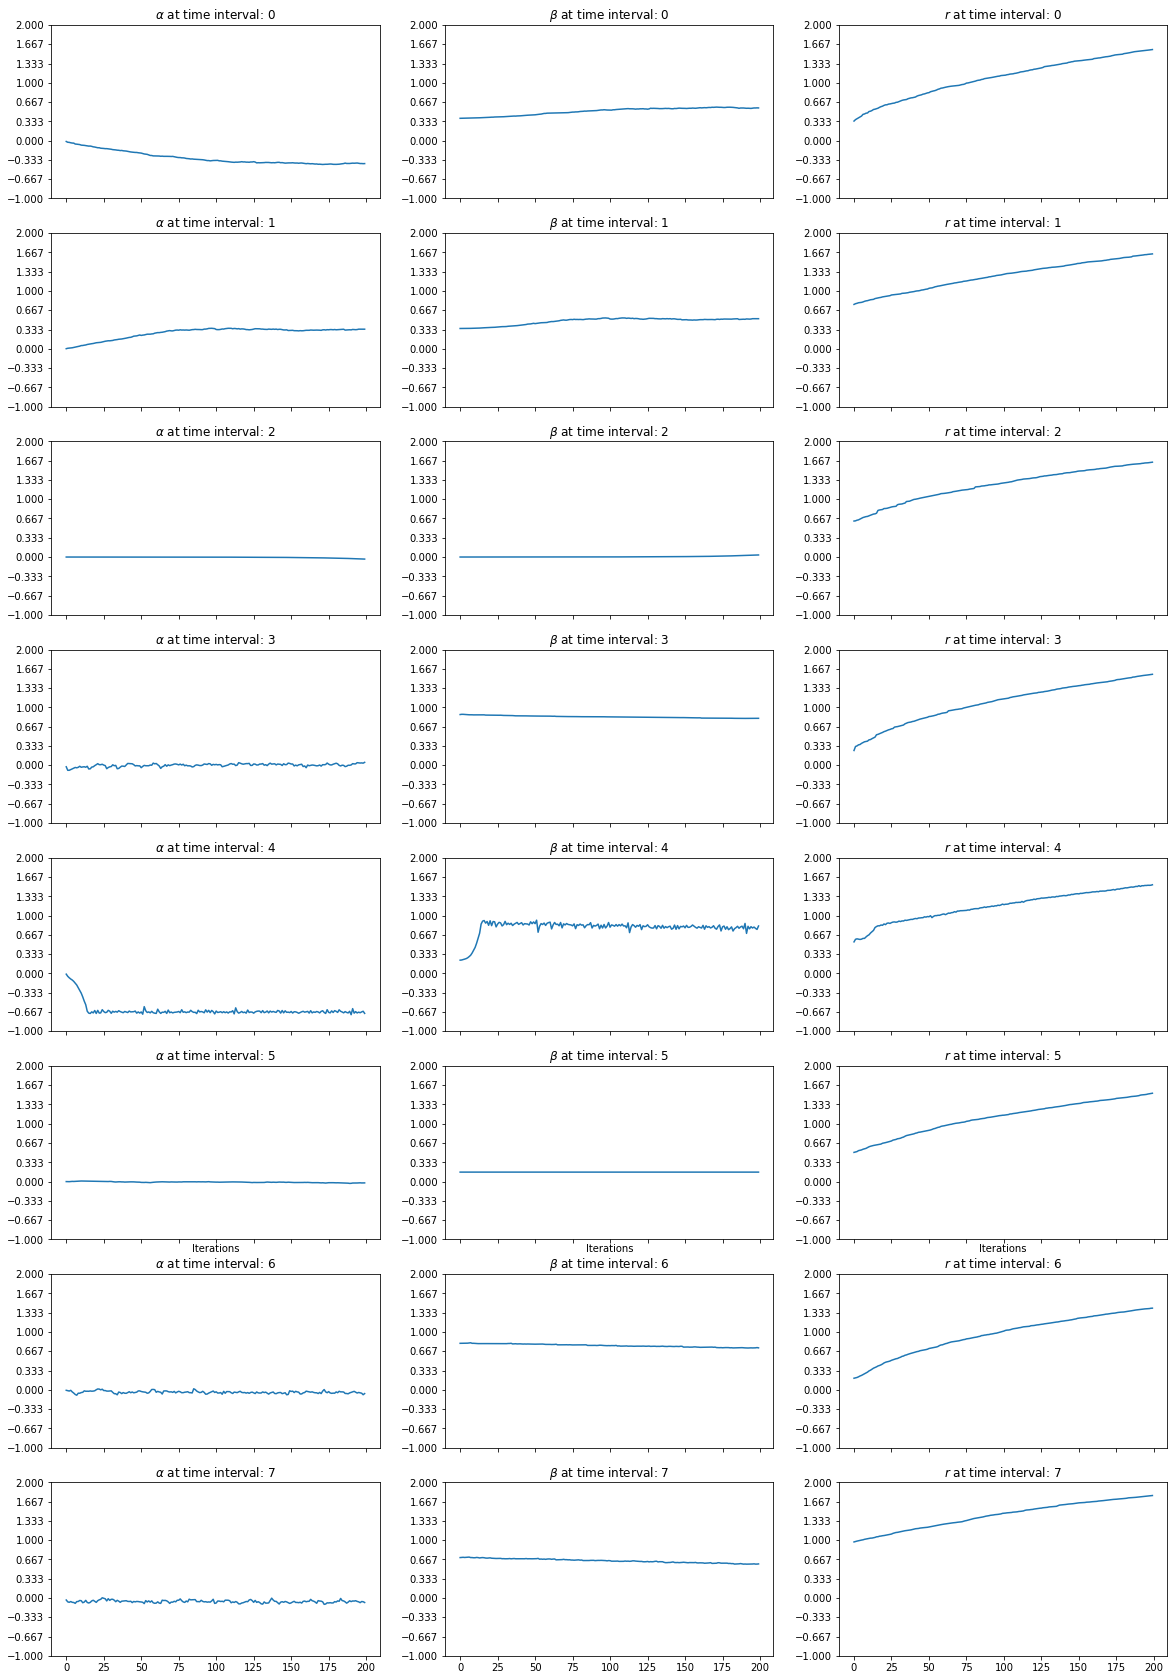

In [143]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$\beta$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    ax.set_yticks(np.linspace(-1,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

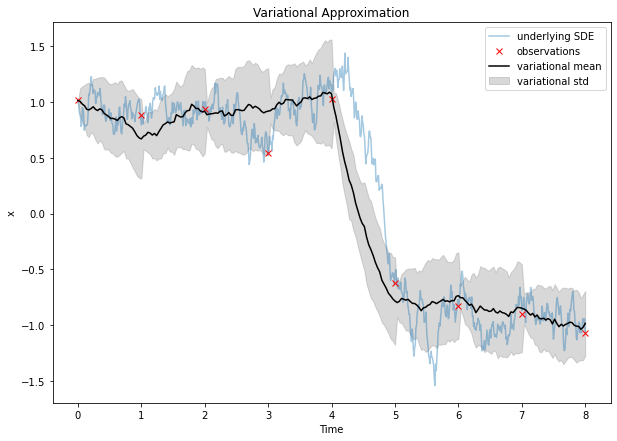

In [140]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 8, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation")
plt.show()